SRC: https://github.com/geohot/ai-notebooks/blob/master/mnist_from_scratch.ipynb

In [120]:
%pylab inline
import numpy as np
from tqdm import trange
from torch.autograd import Variable
import torch
np.set_printoptions(suppress=True)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/siyer/.pyenv/versions/3.10.10/envs/ai/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['save']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# load the mnist dataset

def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [ ]:
# numpy forward pass
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)  
    return x

In [3]:
def numpy_eval():
    Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
    Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
    return (Y_test == Y_test_preds).mean()

In [34]:
# numpy training
def layer_init(m, h):
    # gaussian is strong
    #ret = np.random.randn(m,h)/np.sqrt(m*h)
    # uniform is stronger
    ret = np.random.uniform(-1., 1., size=(m,h))/np.sqrt(m*h)
    return ret.astype(np.float32)

# reinit
np.random.seed(1337)
l1 = layer_init(784, 128)
l2 = layer_init(128, 10)

(784, 128)


In [103]:
# numpy forward and backward pass
def logsumexp(x):
    #return np.log(np.exp(x).sum(axis=1))
    # tlo
    c = x.max(axis=1)
    return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))

In [267]:
def forward_backward(x, y):
    # training
    out = np.zeros((len(y),10), np.float32)
    out[range(out.shape[0]),y] = 1 # one-hot encoding

    # forward pass
    x_l1 = x.dot(l1) # dot product with first layer (BS, 128)
    x_relu = np.maximum(x_l1, 0) # take relu (BS, 128)
    x_l2 = x_relu.dot(l2) # dot product with second layer (BS, 10)
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1)) # subtract all 10 valyes by logsumexp (BS, 10) this is actually softmax
    x_loss = (-out * x_lsm).mean(axis=1) # calculate loss with just mean of -target * x_lsm
    
    # backward pass

    # will involve x_lsm, x_l2, out, d_out and produce dx_sm
    d_out = -out / len(y) # divide - one-hot encodings by batch size?

    # derivative of logsoftmax
    # https://github.com/torch/nn/blob/master/lib/THNN/generic/LogSoftMax.c
    dx_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1, 1))
    print(dx_lsm)
    # derivative of l2
    d_l2 = x_relu.T.dot(dx_lsm)
    dx_relu = dx_lsm.dot(l2.T)

    # derivative of relu
    dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

    # derivative of l1
    d_l1 = x.T.dot(dx_l1)
  
    #return x_loss, x_l2, d_l1, d_l2
    return x_l2, d_l1, d_l2

  0%|                                                                                                                                                                                                                                                                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 555.46it/s]

[[-0.00031427  0.00000628  0.00003589  0.00007358  0.00000043  0.00011257
   0.00006568  0.00000254  0.00001434  0.00000294]
 [ 0.00103939  0.03800993  0.00070066 -0.05480447  0.00085027  0.00127654
   0.0074891   0.00048191  0.00150887  0.00344776]
 [ 0.00009126  0.0032457   0.00007189  0.00037285  0.00037818  0.00004545
   0.0000214  -0.00776216  0.00018158  0.00335379]]


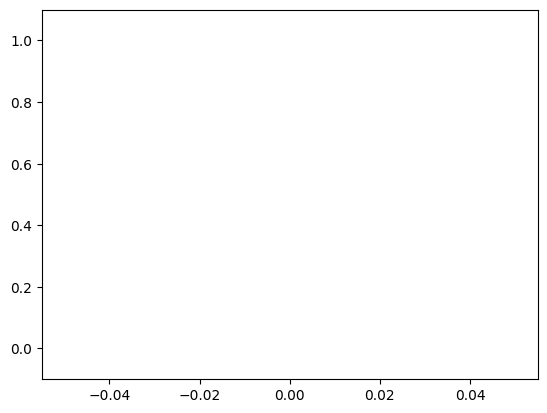

In [268]:
lr = 0.001
BS = 3
losses, accuracies = [], []
for i in (t := trange(1)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = X_train[samp].reshape((-1, 28*28)) # (BS, 784)
    Y = Y_train[samp] # (BS, 1)
    #x_loss, x_l2, d_l1, d_l2 = forward_backward(X, Y)
    x_l2, d_l1, d_l2 = forward_backward(X, Y)

  
    cat = np.argmax(x_l2, axis=1)
    accuracy = (cat == Y).mean()
  
    # SGD
    l1 = l1 - lr*d_l1
    l2 = l2 - lr*d_l2
  
    #loss = x_loss.mean()
    #losses.append(loss)
    accuracies.append(accuracy)
    #t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
    
plt.ylim(-0.1, 1.1)
#plot(losses)
plot(accuracies)

In [110]:
# evaluate on test set
# over 96% with numpy, wow numpy is better than pytorch!
# note: add 0.01% more accuracy with float16
numpy_eval()

0.8418

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 

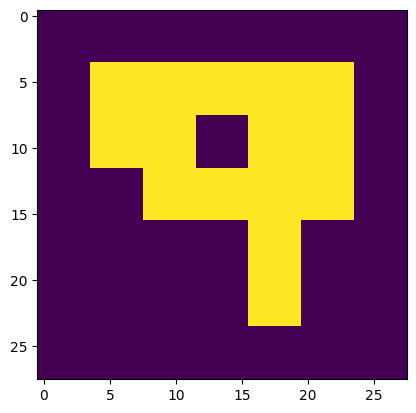

In [22]:
# for fun, can it recognize 4?
m = [[0,0,0,0,0,0,0],
     [0,1,1,1,1,1,0],
     [0,1,1,0,1,1,0],
     [0,0,1,1,1,1,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,0,0,0]]
# upscale to 28x28
m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
print(m)
imshow(m.reshape(28,28))

In [8]:

x = forward(m)
print(x)
np.argmax(x)

[-0.01659154 -0.04620602 -0.03167888  0.0258111   0.02656269 -0.00290025
 -0.06295169  0.0345152   0.05555209  0.05815995]


9

In [256]:
def torch_logsoftmax(input_vectors, target_vectors):
    input_tensor = torch.tensor(input_vectors, requires_grad=True)
    target_vector = torch.tensor(target_vectors)
    logsoftmax_result = torch.nn.functional.log_softmax(input_tensor, dim=-1)
    logsoftmax_result.backward(target_vector)
    logsoftmax_value = logsoftmax_result.detach().numpy()
    derivative_value = input_tensor.grad.detach().numpy()
    return logsoftmax_value, derivative_value


In [355]:
def logsoftmax_numpy(x):
    max_x = np.max(x, axis=-1, keepdims=True)
    logsoftmax_x = x - max_x - np.log(np.sum(np.exp(x - max_x), axis=-1, keepdims=True))
    return logsoftmax_x

def logsoftmax_derivative_numpy(x, target):
    softmax_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    softmax_sum = np.sum(softmax_x, axis=-1, keepdims=True)
    softmax = softmax_x / softmax_sum
    n = x.shape[-1]
    delta_ij = np.eye(n)
    softmax_matrix = np.repeat(softmax[:, np.newaxis, :], n, axis=1)
    derivative = delta_ij - softmax_matrix
    gradient = (derivative.transpose(0, 2, 1) * target[:, np.newaxis, :]).sum(axis=-1)
    return gradient

In [356]:
input_vector = np.array([[1.0, 2.0, 3.0]])
target_vector = np.array([[1.0, 3.0, 2.0]])

In [357]:
torch_logsoftmax(input_vector, target_vector)

(array([[-2.40760596, -1.40760596, -0.40760596]]),
 array([[ 0.45981656,  1.53162917, -1.99144573]]))

In [358]:
logsoftmax_result = logsoftmax_numpy(input_vector)
derivative_result = logsoftmax_derivative_numpy(input_vector, target_vector)
(logsoftmax_result, derivative_result)

(array([[-2.40760596, -1.40760596, -0.40760596]]),
 array([[ 0.45981656,  1.53162917, -1.99144573]]))

In [359]:
input_vectors = np.array([[1.0, 2.0, 3.0, 0.0],
                          [1.0, 3.0, 9.0, 0.0],
                          [4.0, 9.0, 2.0, 0.0],
                          [0.0, 4.0, 3.0, 0.0],])
# Target vector
target_vectors = np.array([[1.0, 3.0, 2.0, 2.0],
                          [1.0, -4.0, -10.0, 3.0],
                          [3.0, 8.0, 2.0, 1.0],
                          [0.0, 4.0, 3.0, 1.0]])  # Corrected target


In [360]:
torch_logsoftmax(input_vectors, target_vectors)

(array([[-2.4401897 , -1.4401897 , -0.4401897 , -3.4401897 ],
        [-8.00293332, -6.00293332, -0.00293332, -9.00293332],
        [-5.00774318, -0.00774318, -7.00774318, -9.00774318],
        [-4.339689  , -0.339689  , -1.339689  , -4.339689  ]]),
 array([[ 0.30284545,  1.10493746, -3.15131408,  1.74353117],
        [ 1.0033448 , -3.97528508, -0.0292902 ,  3.00123048],
        [ 2.90639635, -5.89201406,  1.98733212,  0.99828559],
        [-0.10432467, -1.69593375,  0.90458308,  0.89567533]]))

In [361]:
logsoftmax_result = logsoftmax_numpy(input_vectors)
derivative_result = logsoftmax_derivative_numpy(input_vectors, target_vectors)
(logsoftmax_result, derivative_result)

(array([[-2.4401897 , -1.4401897 , -0.4401897 , -3.4401897 ],
        [-8.00293332, -6.00293332, -0.00293332, -9.00293332],
        [-5.00774318, -0.00774318, -7.00774318, -9.00774318],
        [-4.339689  , -0.339689  , -1.339689  , -4.339689  ]]),
 array([[ 0.30284545,  1.10493746, -3.15131408,  1.74353117],
        [ 1.0033448 , -3.97528508, -0.0292902 ,  3.00123048],
        [ 2.90639635, -5.89201406,  1.98733212,  0.99828559],
        [-0.10432467, -1.69593375,  0.90458308,  0.89567533]]))

In [362]:
def torch_relu(input_vectors, target_vectors):
    input_tensor = torch.tensor(input_vectors, requires_grad=True)
    target_vector = torch.tensor(target_vectors)
    relu_result = torch.nn.functional.relu(input_tensor)
    relu_result.backward(target_vector)
    relu_value = relu_result.detach().numpy()
    derivative_value = input_tensor.grad.detach().numpy()
    return relu_value, derivative_value


In [363]:
def relu_numpy(x):
    return np.maximum(x, 0)

def relu_derivative_numpy(x, target):
    return (x > 0) * target

In [364]:
torch_relu(input_vectors, target_vectors)

(array([[1., 2., 3., 0.],
        [1., 3., 9., 0.],
        [4., 9., 2., 0.],
        [0., 4., 3., 0.]]),
 array([[  1.,   3.,   2.,   0.],
        [  1.,  -4., -10.,   0.],
        [  3.,   8.,   2.,   0.],
        [  0.,   4.,   3.,   0.]]))

In [365]:
relu_result = relu_numpy(input_vectors)
derivative_result = relu_derivative_numpy(input_vectors, target_vectors)
(relu_result, derivative_result)

(array([[1., 2., 3., 0.],
        [1., 3., 9., 0.],
        [4., 9., 2., 0.],
        [0., 4., 3., 0.]]),
 array([[  1.,   3.,   2.,   0.],
        [  1.,  -4., -10.,   0.],
        [  3.,   8.,   2.,   0.],
        [  0.,   4.,   3.,   0.]]))